In [3]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.6/356.6 kB 6.6 MB/s eta 0:00:00 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.6.0-py2.py3-none-any.whl size=351311 sha256=697991271cf56d3c67b73e9704da7c0ece7ab1594f045ae82212a4e69373ccfa
  Stored in directory: /home/selwyn/.cache/pip/wheels/a9/25/66/ae46b49b24c976a140abb666a8d84a74062c65cc4de5f78c57
Successfully built emoji


In [1]:
import pandas as pd
import json
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import tweepy
import emoji
import nltk
import nest_asyncio
import string
import time
import glob

from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

nest_asyncio.apply()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/selwyn/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# If you can still run Tweepy, use this for accessing it. Just change the path to your access.json
path = 'C:/Users/User/Desktop/Year 3 Sem 3/social-media-computing-twitter/'

secrets = json.loads(open(path+'access.json').read())

consumer_key = secrets['consumer_key'].replace('"', '')
consumer_secret = secrets['consumer_secret'].replace('"', '')
access_token = secrets['access_token'].replace('"', '')
access_token_secret = secrets['access_token_secret'].replace('"', '')

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

try:
    api.verify_credentials()
    print("Authentication Successful")
except:
    print("Authentication Error")


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/User/Desktop/Year 3 Sem 3/social-media-computing-twitter/access.json'

In [4]:
# api.rate_limit_status()

# Load Data

In [5]:
# Returns 3 dataframes for:
# 1. User timeline tweets obtained with Tweepy
# 2. Scraped data which contains the views of the tweets using Selenium
# 3. 30 day historical data that tracks followers, followings, and tweets from Social Blade
def load_all_tweets_views_historical_json():
    # User Timeline Tweets
    dataframes = []
    pattern = r"UserTimeline_(\w+)\.json"
    
    for filename in os.listdir("data"):
        match = re.search(pattern, filename)
        if match is not None:
            temp_df = pd.read_json(f"data/{filename}", convert_dates = ["created_at"])
            temp_df["username"] = match.group(1)
            dataframes.append(temp_df)
    
    results = pd.concat(dataframes)
    results = results[['username'] + list(results.columns[:-1])]
    
    # Scraped data for views 
    dataframes = []
    pattern = r"output_selenium_(\w+)\.json"
    for filename in os.listdir("selenium_scraper"):
        match = re.search(pattern, filename)
        if match is not None:
            temp_df = pd.read_json(f"selenium_scraper/{filename}", orient="index", convert_dates = ["created_at"])
            temp_df["username"] = match.group(1)
            dataframes.append(temp_df)

    results_view = pd.concat(dataframes)
    results_view = results_view[['username'] + list(results_view.columns[:-1])].reset_index().rename(columns={'index':'link'})

    # 30 day historical data
    dataframes = []
    pattern = r"Historical30d_(\w+)\.csv"
    for filename in os.listdir("data"):
        match = re.search(pattern, filename)
        if match:
            profile = match.group(1)
            filepath = os.path.join("data", filename)
            df = pd.read_csv(filepath)
            df['username'] = profile  # Add a 'Profile' column to identify the data source
            dataframes.append(df)
    results_historical = pd.concat(dataframes, ignore_index=True)
    results_historical = results_historical[['username'] + list(results_historical.columns[:-1])]

    results_historical['date'] = pd.to_datetime(results_historical['date'])
    results_historical['followers'] = results_historical[' followers']
    results_historical['following'] = results_historical[' following']
    results_historical['tweets'] = results_historical[' tweets']
    
    results_historical.drop([' followers', ' following', ' tweets'], axis=1, inplace=True)

    return results, results_view, results_historical

df, df_views, df_historical = load_all_tweets_views_historical_json()
df_historical



,username,date,followers,following,tweets
0,TheOnion,2023-05-03,11810095,7,98055
1,TheOnion,2023-05-04,11808699,7,98082
2,TheOnion,2023-05-05,11807785,7,98084
3,TheOnion,2023-05-06,11807486,7,98106
4,TheOnion,2023-05-07,11806391,7,98128
...,...,...,...,...,...
111,TheBabylonBee,2023-05-29,2639843,9,21334
112,TheBabylonBee,2023-05-30,2642757,9,21347
113,TheBabylonBee,2023-05-31,2645716,9,21365
114,TheBabylonBee,2023-06-01,2652830,10,21391


# Process Data

In [6]:
# Pulls "day of the week" and "hour of the day" from `created_at`
def process_dates(df):
    temp_df = df.copy()
    
    temp_df["day_of_week"] = df["created_at"].dt.day_name()
    temp_df["hour_of_day"] = df["created_at"].dt.hour
    
    return temp_df

df = process_dates(df)
df

,username,created_at,id,id_str,text,truncated,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status,day_of_week,hour_of_day
0,Reductress,2023-06-02 21:00:49+00:00,1664738866065031176,1664738866065031168,"Hairstylist Fails to Replicate Face, Body, Lif...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664738864534024193, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,42,764,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,21
1,Reductress,2023-06-02 20:01:26+00:00,1664723920442851328,1664723920442851328,Cool! This Woman Either Has No Unread Emails o...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664723918328832002, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,20,188,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,20
2,Reductress,2023-06-02 19:01:09+00:00,1664708749158764569,1664708749158764544,Mermaidcore! This Woman Hasn't Gotten Up or Wa...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664708747954999307, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,55,464,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,19
3,Reductress,2023-06-02 18:11:34+00:00,1664696272639459330,1664696272639459328,"Get the ""HOMOSEXUAL"" beer coozies and more in ...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664696266176057350, 'id_str...","<a href=""https://about.twitter.com/products/tw...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,4,108,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,18
4,Reductress,2023-06-02 18:02:06+00:00,1664693889767288838,1664693889767288832,How to Have Dinner With Your Parents Without D...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664693888366379008, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,43,723,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231,HardDriveMag,2022-05-28 19:00:00+00:00,1530624950247227393,1530624950247227392,Board Game Winner Devastated to Learn Friend A...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,93,1151,False,False,0.0,en,NaN,NaN,NaN,NaN,Saturday,19
3232,HardDriveMag,2022-05-28 17:00:13+00:00,1530594807764209664,1530594807764209664,Video Game Speedrunner Changes Boyfriend’s Lan...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,284,2247,False,False,0.0,en,NaN,NaN,NaN,NaN,Saturday,17
3233,HardDriveMag,2022-05-28 15:00:09+00:00,1530564588638461953,1530564588638461952,Zodiac Killer Letter Solved by Opening It With...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,596,5593,False,False,0.0,en,NaN,NaN,NaN,NaN,Saturday,15
3234,HardDriveMag,2022-05-28 13:00

In [7]:
def text_clean(text):
    # remove hashtags as they do not have any effect on sentiment analysis
    text = re.sub(r'#\w+', '', str(text))

    # remove mentions as they do not have any effect on sentiment analysis
    text = re.sub(r'@\w+', '', str(text))

    # remove the word 'RT' as they do only indicate retweets 
    text = ' '.join(word for word in text.split() if word.lower() != 'rt')

    # removes any occurences of any URLs in the text because they do not affect sentiment analysis as well
    text = re.sub(r'\b\w*http\w*\S*', '', str(text))

    # remove any occurrences of any punctuation characters to only filter just the words. 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', str(text)) 

    # lower case for all words to help with reducing noise 
    text = str(text).lower() 

    # convert emojis to words instead for use in identifying sentiments using emoji. Also removing the ":" and adding a space after the emoji to get only the string of the emoji used
    text = emoji.demojize(str(text))
    text = text.replace(":"," ")
    text = ' '.join(text.split())

    return text

cleaned = lambda x: text_clean(x)

df['cleaned_text'] = pd.DataFrame(df['text'].apply(cleaned))
my_column = df.pop('cleaned_text')
df.insert(5, 'cleaned_text', my_column)
df

,username,created_at,id,id_str,text,cleaned_text,truncated,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status,day_of_week,hour_of_day
0,Reductress,2023-06-02 21:00:49+00:00,1664738866065031176,1664738866065031168,"Hairstylist Fails to Replicate Face, Body, Lif...",hairstylist fails to replicate face body lifes...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664738864534024193, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,42,764,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,21
1,Reductress,2023-06-02 20:01:26+00:00,1664723920442851328,1664723920442851328,Cool! This Woman Either Has No Unread Emails o...,cool this woman either has no unread emails or...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664723918328832002, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,20,188,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,20
2,Reductress,2023-06-02 19:01:09+00:00,1664708749158764569,1664708749158764544,Mermaidcore! This Woman Hasn't Gotten Up or Wa...,mermaidcore this woman hasnt gotten up or walk...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664708747954999307, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,55,464,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,19
3,Reductress,2023-06-02 18:11:34+00:00,1664696272639459330,1664696272639459328,"Get the ""HOMOSEXUAL"" beer coozies and more in ...",get the homosexual beer coozies and more in ou...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664696266176057350, 'id_str...","<a href=""https://about.twitter.com/products/tw...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,4,108,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,18
4,Reductress,2023-06-02 18:02:06+00:00,1664693889767288838,1664693889767288832,How to Have Dinner With Your Parents Without D...,how to have dinner with your parents without d...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664693888366379008, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,43,723,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231,HardDriveMag,2022-05-28 19:00:00+00:00,1530624950247227393,1530624950247227392,Board Game Winner Devastated to Learn Friend A...,board game winner devastated to learn friend a...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,93,1151,False,False,0.0,en,NaN,NaN,NaN,NaN,Saturday,19
3232,HardDriveMag,2022-05-28 17:00:13+00:00,1530594807764209664,1530594807764209664,Video Game Speedrunner Changes Boyfriend’s Lan...,video game speedrunner changes boyfriend’s lan...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,284,2247,False,False,0.0,en,NaN,NaN,NaN,NaN,Saturday,17
3233,HardDriveMag,2022-05-28 15:00:09+00:00,1530564588638461953,153056

## Metrics for Monitoring

### Impressions  

Measures the number of views a tweet was seen on Twitter. This data was scraped using Selenium and is stored in our dataset. 

### Audience Growth Rate

Measures the change in followers of the user over a certain period of time. This data was obtained from Social Blade and is stored in our dataset. 

Formula: Audience Growth Rate = ((Ending Followers - Starting Followers) / Starting Followers) * 100

### Average Engagement Rate
Measures the number of engagements a tweet gets, to the total number of followers. 

Formula: 
Average Engagement Rate = (likes + shares) / (total followers)

In [8]:
def process_avg_engagement_rate(df):
    temp_df = df.copy()
    
    temp_df["avg_engagement_rate"] = temp_df.apply(lambda row : (row["favorite_count"] + row["retweet_count"]) / row["user"]["followers_count"], axis = 1)
    return temp_df

df = process_avg_engagement_rate(df)

### Amplification Rate
Measures the ratio of shares per post to the total number of overall followers.

Formula: Amplification Rate = (shares) / (total followers)

In [9]:
def process_amplification_rate(df): 
    temp_df = df.copy()
    
    temp_df["amplification_rate"] = temp_df.apply(lambda row : row["retweet_count"] / row["user"]["followers_count"], axis = 1)
    return temp_df

df = process_amplification_rate(df)

### Tweet Sentiment Score

Measures the Sentiment score of the tweet. Allows us to track the sentiment of the tweet that is published by the author. VADER Sentiment Analysis is used for the scoring. 

In [10]:
def process_tweet_sentiment(df): 
    temp_df = df.copy()
    sid = SentimentIntensityAnalyzer()
    temp_df["tweet_VADER_sentiment"] = temp_df['cleaned_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
    return temp_df

df = process_tweet_sentiment(df)

# Basic Functions

In [11]:
# Given a pandas series, return the link of the tweet
def get_tweet_link(series):
    username = series["user"]["screen_name"]
    return f"https://twitter.com/{username}/status/{series['id']}"

tweet_link = get_tweet_link(df.iloc[0])
tweet_link

'https://twitter.com/Reductress/status/1664738866065031176'

In [12]:
def find_retweets(df):
    return df[df["retweeted_status"].notnull()]

df_retweets = find_retweets(df)
df_retweets

,username,created_at,id,id_str,text,cleaned_text,truncated,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status,day_of_week,hour_of_day,avg_engagement_rate,amplification_rate,tweet_VADER_sentiment
8,Reductress,2023-06-02 14:35:20+00:00,1664641855055691777,1664641855055691776,"RT @Reductress: ""How to Stay Productive When T...",how to stay productive when the world is endin...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://about.twitter.com/products/tw...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,13,0,False,False,NaN,en,{'created_at': 'Thu Jun 01 14:22:15 +0000 2023...,NaN,NaN,NaN,Friday,14,0.000043,0.000043,0.0000
43,Reductress,2023-05-29 14:08:45+00:00,1663185614265524224,1663185614265524224,RT @AndrewsMcMeel: How to Stay Productive When...,how to stay productive when the world is endin...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://about.twitter.com/products/tw...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,6,0,False,False,NaN,en,{'created_at': 'Mon May 29 14:01:08 +0000 2023...,NaN,NaN,NaN,Monday,14,0.000020,0.000020,0.0000
95,Reductress,2023-05-23 15:01:15+00:00,1661024498722934791,1661024498722934784,"RT @Reductress: The ""Extremely Gay and Brave"" ...",the extremely gay and brave tee available for ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1659622221399183362, 'id_str...","<a href=""https://about.twitter.com/products/tw...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,16,0,False,False,0.0,en,{'created_at': 'Fri May 19 18:09:18 +0000 2023...,NaN,NaN,NaN,Tuesday,15,0.000052,0.000052,0.5667
139,Reductress,2023-05-18 13:55:31+00:00,1659196015780708353,1659196015780708352,RT @AndrewsMcMeel: From “’Doing What You Love’...,from “’doing what you love’ and why that’s bad...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://about.twitter.com/products/tw...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,7,0,False,False,NaN,en,{'created_at': 'Thu May 18 13:00:11 +0000 2023...,NaN,NaN,NaN,Thursday,13,0.000023,0.000023,0.4404
167,Reductress,2023-05-15 14:15:45+00:00,1658113944345620480,1658113944345620480,RT @UnionHallNY: TONIGHT: @Reductress Presents...,tonight presents hahawow with associate editor...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://about.twitter.com/products/tw...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,4,0,False,False,NaN,en,{'created_at': 'Mon May 15 13:00:02 +0000 2023...,NaN,NaN,NaN,Monday,14,0.000013,0.000013,0.4019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3205,HardDriveMag,2022-05-31 02:33:50+00:00,1531463935454593032,1531463935454593024,RT @PtakTestKitchen: This show in July will be...,this show in july will be a safe space for gam...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,True,22,0,False,False,NaN,en,{'created_at': 'Mon May 30 22:43:47 +0000 2022...,1.531354e+18,1.531354e+18,NaN,Tuesday,2,0.000068,0.000068,0.4404
3207,HardDriveMag,2022-05-30 21:08:23+00:00,1531382034144305152,1531382034144305152,RT @Clbgolden: @HardDriveMag 💀💀 https://t.co/o...,skull skull,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [

In [13]:
def find_not_retweets(df):
    return df[df["retweeted_status"].isna()]

df_not_retweets = find_not_retweets(df)
df_not_retweets

,username,created_at,id,id_str,text,cleaned_text,truncated,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status,day_of_week,hour_of_day,avg_engagement_rate,amplification_rate,tweet_VADER_sentiment
0,Reductress,2023-06-02 21:00:49+00:00,1664738866065031176,1664738866065031168,"Hairstylist Fails to Replicate Face, Body, Lif...",hairstylist fails to replicate face body lifes...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664738864534024193, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,42,764,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,21,0.002644,0.000138,-0.4215
1,Reductress,2023-06-02 20:01:26+00:00,1664723920442851328,1664723920442851328,Cool! This Woman Either Has No Unread Emails o...,cool this woman either has no unread emails or...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664723918328832002, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,20,188,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,20,0.000682,0.000066,0.0258
2,Reductress,2023-06-02 19:01:09+00:00,1664708749158764569,1664708749158764544,Mermaidcore! This Woman Hasn't Gotten Up or Wa...,mermaidcore this woman hasnt gotten up or walk...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664708747954999307, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,55,464,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,19,0.001703,0.000180,0.0000
3,Reductress,2023-06-02 18:11:34+00:00,1664696272639459330,1664696272639459328,"Get the ""HOMOSEXUAL"" beer coozies and more in ...",get the homosexual beer coozies and more in ou...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664696266176057350, 'id_str...","<a href=""https://about.twitter.com/products/tw...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,4,108,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,18,0.000367,0.000013,0.3947
4,Reductress,2023-06-02 18:02:06+00:00,1664693889767288838,1664693889767288832,How to Have Dinner With Your Parents Without D...,how to have dinner with your parents without d...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1664693888366379008, 'id_str...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,43,723,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,18,0.002513,0.000141,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3231,HardDriveMag,2022-05-28 19:00:00+00:00,1530624950247227393,1530624950247227392,Board Game Winner Devastated to Learn Friend A...,board game winner devastated to learn friend a...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,93,1151,False,False,0.0,en,NaN,NaN,NaN,NaN,Saturday,19,0.003860,0.000289,0.8481
3232,HardDriveMag,2022-05-28 17:00:13+00:00,1530594807764209664,1530594807764209664,Video Game Speedrunner Changes Boyfriend’s Lan...,video game speedrunner changes boyfriend’s lan...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://buffer.com"" rel=""nofollow"">Bu..

# Basic Statistics

### Top Tweets

In [14]:
# Top 5 tweets with most likes (favorited)
def most_liked_tweets(df, count):
    return df.sort_values(by = ["favorite_count"], ascending = False).head(count)


def most_liked_tweets_by_users(df, count = 5):
    usernames = pd.unique(df["username"])
    results = {}
    for username in usernames:
        results[username] = most_liked_tweets(df[df["username"] == username], count)
    return results
    

dfs_top5 = most_liked_tweets_by_users(df, 50)
dfs_top5["HardDriveMag"]

,username,created_at,id,id_str,text,cleaned_text,truncated,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status,day_of_week,hour_of_day,avg_engagement_rate,amplification_rate,tweet_VADER_sentiment
3206,HardDriveMag,2022-05-30 22:27:35+00:00,1531401966567493634,1531401966567493632,Hard Drive Apologizes to Elon Musk for Dunking...,hard drive apologizes to elon musk for dunking...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,18114,156960,False,False,0.0,en,NaN,NaN,NaN,NaN,Monday,22,0.543263,0.056209,0.1779
3216,HardDriveMag,2022-05-30 18:02:52+00:00,1531335346826379266,1531335346826379264,@elonmusk well you're the expert on SNL's bad ...,well youre the expert on snls bad days,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1531334820160319489, 'id_str...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.531334e+18,1.531334e+18,44196397.0,44196397.0,elonmusk,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,12079,149901,False,False,0.0,en,NaN,NaN,NaN,NaN,Monday,18,0.502631,0.037482,-0.3400
3218,HardDriveMag,2022-05-30 17:23:30+00:00,1531325439997788160,1531325439997788160,@elonmusk ok well lemme know what you think ab...,ok well lemme know what you think about this one,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",1.531320e+18,1.531320e+18,44196397.0,44196397.0,elonmusk,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,3759,93669,False,False,0.0,en,NaN,NaN,NaN,NaN,Monday,17,0.302324,0.011664,0.5106
2213,HardDriveMag,2022-10-06 20:12:24+00:00,1578115981351833600,1578115981351833600,who would have thought that chris pratt's big ...,who would have thought that chris pratts big s...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,6430,89611,False,False,NaN,en,NaN,NaN,NaN,NaN,Thursday,20,0.298020,0.019953,0.0000
3208,HardDriveMag,2022-05-30 20:47:48+00:00,1531376856292904965,1531376856292904960,Elon Musk Offers to Buy Rake He Stepped On\n\n...,elon musk offers to buy rake he stepped on,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,6710,81933,False,False,0.0,en,NaN,NaN,NaN,NaN,Monday,20,0.275063,0.020821,0.0000
3083,HardDriveMag,2022-06-14 21:26:05+00:00,1536822307565580290,1536822307565580288,we're just a buncha guys writing about waluigi...,were just a buncha guys writing about waluigis...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,True,7118,79105,False,False,0.0,en,NaN,1.536820e+18,1.536820e+18,{'created_at': 'Tue Jun 14 21:17:22 +0000 2022...,Tuesday,21,0.267554,0.022087,0.2235
1953,HardDriveMag,2022-11-04 17:00:07+00:00,1588576839085293569,1588576839085293568,Six Dead After Jerma Lets Twitch Vote on When ...,six dead after jerma lets twitch vote on when ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,9068,76456,False,False,0.0,en,NaN,NaN,NaN,NaN,Friday,17,0.265385,0.028138,-

In [15]:
get_tweet_link(dfs_top5["HardDriveMag"].iloc[7])

'https://twitter.com/HardDriveMag/status/1569364774999179265'

In [16]:
def find_average_by_users(dataframes, column_name, avg_type = "mean"):
    usernames = pd.unique(df["username"])
    results = {}
    for username in usernames:
        if avg_type == "mean":
            results[username] = df[df["username"] == username][column_name].mean()
        elif avg_type == "median":
            results[username] = df[df["username"] == username][column_name].median()
    return results


print("Mean favorites   : ")
for username, mean in find_average_by_users(df_not_retweets, "favorite_count", "mean").items():
    print(f"{username:16} : {mean:.2f}")

print("-----\n")

print("Median favorites : ")
for username, median in find_average_by_users(df_not_retweets, "favorite_count", "median").items():
    print(f"{username:16} : {median}")

Mean favorites   : 
Reductress       : 707.47
TheOnion         : 1848.31
TheBabylonBee    : 6833.81
HardDriveMag     : 2877.49
-----

Median favorites : 
Reductress       : 385.0
TheOnion         : 805.0
TheBabylonBee    : 3295.0
HardDriveMag     : 1545.0


## Mean and Median stats

### Impressions

In [17]:
usernames = pd.unique(df["username"])
results_mean = {}
results_median = {}
    
for username in usernames:
    results_mean[username] = df_views[df_views["username"] == username]['views'].mean()
    results_median[username] = df_views[df_views["username"] == username]['views'].median()

print("Mean Impressions   : ")
for username, mean in results_mean.items():
    print(f"{username:16} : {mean:.6f}")
    
print("-----\n")

print("Median Impressions   : ")
for username, median in results_median.items():
    print(f"{username:16} : {median:.6f}")


Mean Impressions   : 
Reductress       : 68456.113001
TheOnion         : 384517.104242
TheBabylonBee    : 835498.958589
HardDriveMag     : 314249.483395
-----

Median Impressions   : 
Reductress       : 48133.000000
TheOnion         : 277243.000000
TheBabylonBee    : 456122.500000
HardDriveMag     : 102845.500000


### Engagement Rate

In [18]:
print("Mean engagement rate   : ")
for username, mean in find_average_by_users(df_not_retweets, "avg_engagement_rate", "mean").items():
    print(f"{username:16} : {mean:.6f}")
    
print("-----\n")

print("Median engagement rate   : ")
for username, median in find_average_by_users(df_not_retweets, "avg_engagement_rate", "median").items():
    print(f"{username:16} : {median:.6f}")

Mean engagement rate   : 
Reductress       : 0.002555
TheOnion         : 0.000172
TheBabylonBee    : 0.002942
HardDriveMag     : 0.009977
-----

Median engagement rate   : 
Reductress       : 0.001389
TheOnion         : 0.000073
TheBabylonBee    : 0.001422
HardDriveMag     : 0.005253


### Amplification Rate

In [19]:
print("Mean amplification rate   : ")
for username, mean in find_average_by_users(df_not_retweets, "amplification_rate", "mean").items():
    print(f"{username:16} : {mean:.6f}")
    
print("-----\n")

print("Median amplification rate   : ")
for username, median in find_average_by_users(df_not_retweets, "amplification_rate", "median").items():
    print(f"{username:16} : {median:.6f}")

Mean amplification rate   : 
Reductress       : 0.000234
TheOnion         : 0.000015
TheBabylonBee    : 0.000394
HardDriveMag     : 0.001048
-----

Median amplification rate   : 
Reductress       : 0.000121
TheOnion         : 0.000005
TheBabylonBee    : 0.000163
HardDriveMag     : 0.000416


### Tweet Sentiment Score

In [20]:
print("Mean amplification rate   : ")
for username, mean in find_average_by_users(df_not_retweets, "tweet_VADER_sentiment", "mean").items():
    print(f"{username:16} : {mean:.6f}")
    
print("-----\n")

print("Median amplification rate   : ")
for username, median in find_average_by_users(df_not_retweets, "tweet_VADER_sentiment", "median").items():
    print(f"{username:16} : {median:.6f}")

Mean amplification rate   : 
Reductress       : 0.039510
TheOnion         : 0.005897
TheBabylonBee    : -0.001592
HardDriveMag     : -0.005993
-----

Median amplification rate   : 
Reductress       : 0.000000
TheOnion         : 0.000000
TheBabylonBee    : 0.000000
HardDriveMag     : 0.000000


### For exporting csv file to plot dashboard.py. Uncomment to get csv. 

In [21]:
# df_not_retweets.to_csv('data_with_metrics.csv', index=False)
# df_views.to_csv('data_views.csv', index=False)

# Plots (shown in streamlit)

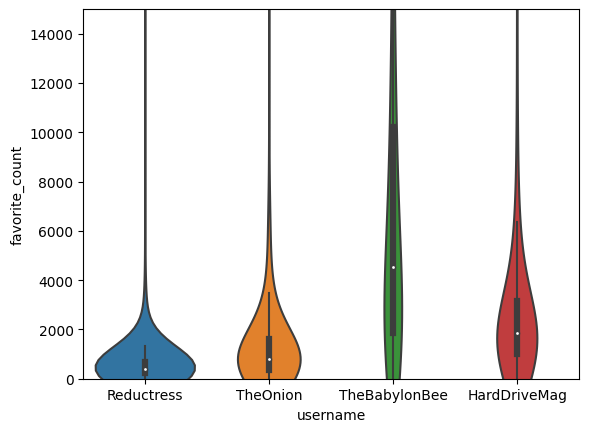

In [22]:
# Plot favorite count of each user using a violin plot
def plot_favorite_count_by_user(df):
    fig, ax = plt.subplots()
    sns.violinplot(data = df, x = "username", y = "favorite_count", gridsize = 1000)
    ax.set_ylim(0, 15000)
    plt.show()
    
    
plot_favorite_count_by_user(df_not_retweets)

In [23]:
# Plot 4 subplots of counts of tweets by hour of the day
def plot_tweet_counts(df, column_name, order):
    grid = sns.FacetGrid(data = df, col = "username", col_wrap = 2, aspect = 1.5, height = 4, sharex = False, sharey = False)
    
    grid.map(sns.countplot, column_name, order = order)
    grid.set_axis_labels(column_name, "Count")
    grid.set_titles('{col_name}')
    plt.subplots_adjust(hspace=0.4)
    
    plt.show()

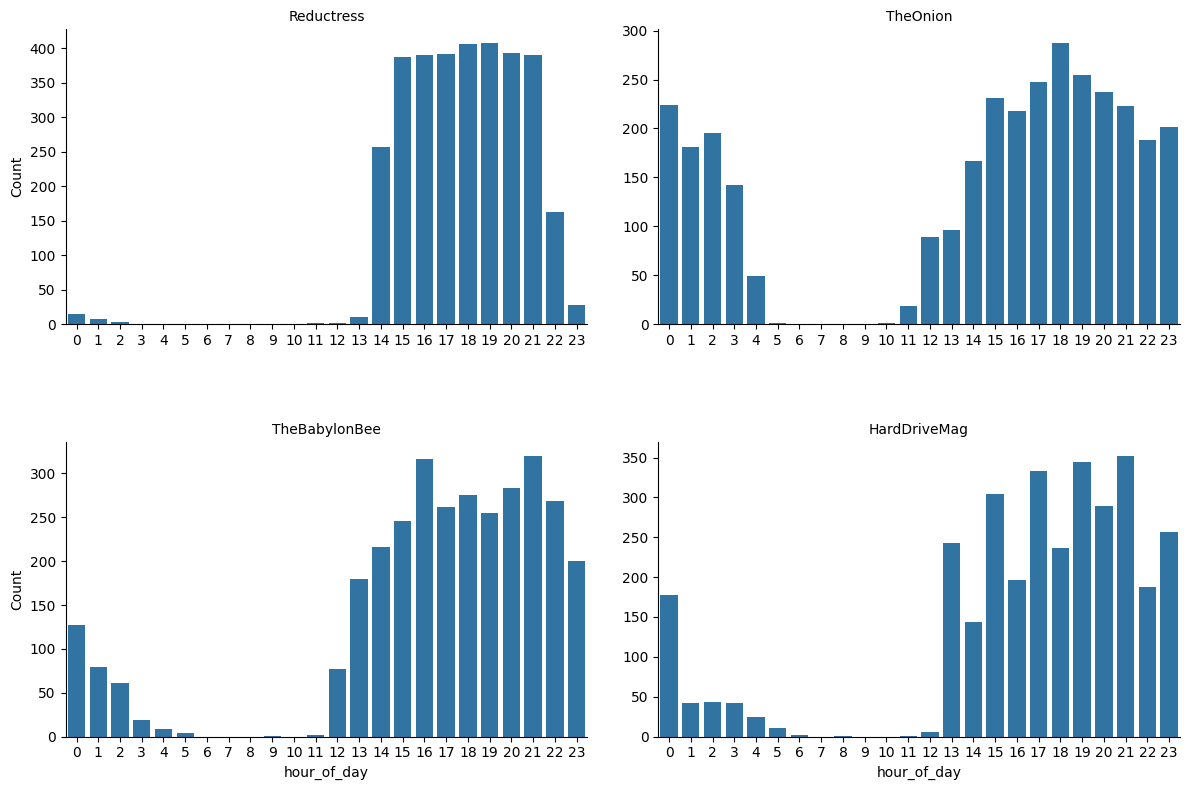

In [24]:
plot_tweet_counts(df, "hour_of_day", [i for i in range(24)])

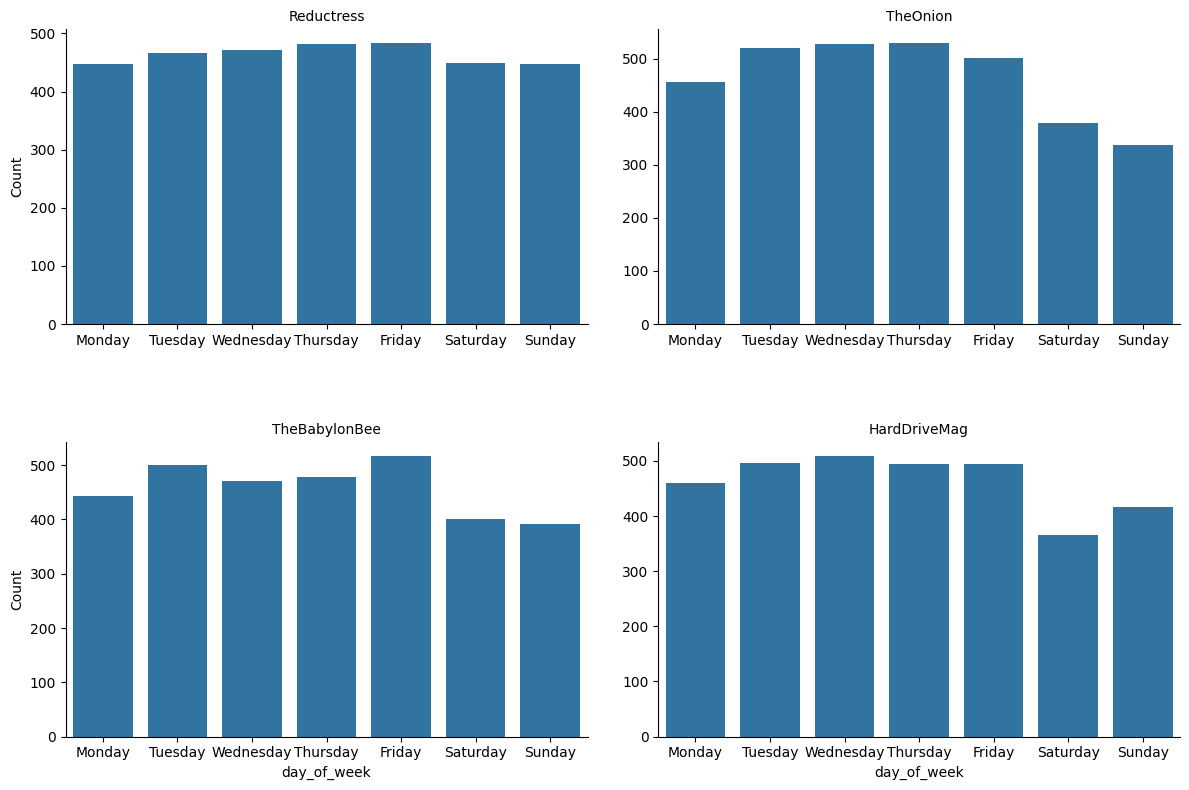

In [25]:
plot_tweet_counts(df, "day_of_week", ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

### Total Average Engagement by Time

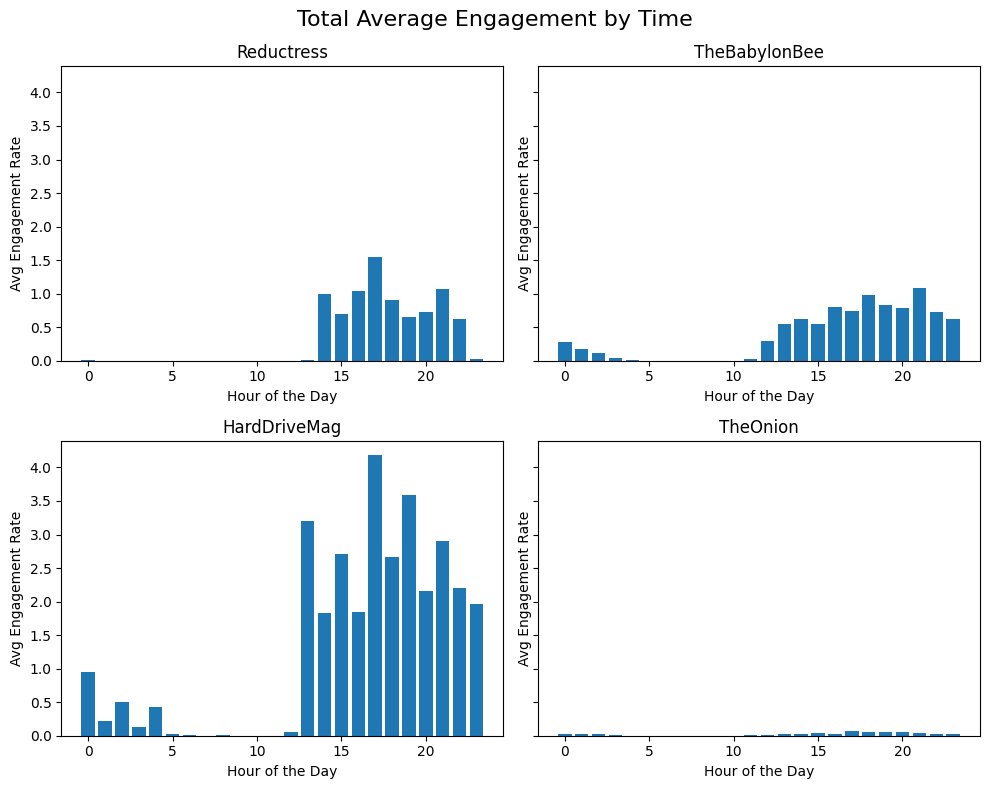

In [26]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharey=True)

names = ['Reductress', 'TheBabylonBee', 'HardDriveMag', 'TheOnion']

fig.suptitle('Total Average Engagement by Time', fontsize=16)

# Plot the counts of retweets for each hour in each subplot
for i, ax in enumerate(axs.flatten()):
    subset_df = df_not_retweets[df_not_retweets['username'] == names[i]]  
    retweet_counts = subset_df.groupby('hour_of_day')['avg_engagement_rate'].sum()
    ax.bar(retweet_counts.index, retweet_counts.values)
    ax.set_title(f'{names[i]}')
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Avg Engagement Rate')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

/tmp/ipykernel_11405/4068221517.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['day_of_week'] = pd.Categorical(subset_df['day_of_week'], categories=day_order, ordered=True)
/tmp/ipykernel_11405/4068221517.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['day_of_week'] = pd.Categorical(subset_df['day_of_week'], categories=day_order, ordered=True)
/tmp/ipykernel_11405/4068221517.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

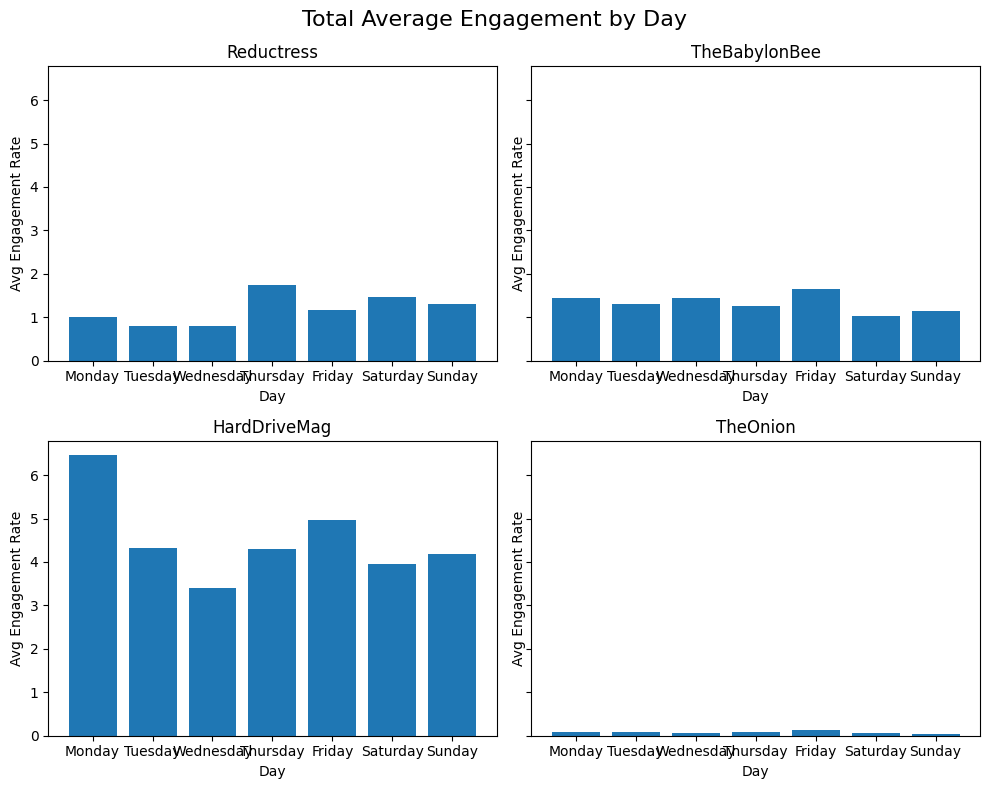

In [27]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharey=True)

names = ['Reductress', 'TheBabylonBee', 'HardDriveMag', 'TheOnion']

fig.suptitle('Total Average Engagement by Day', fontsize=16)

# Sort the days of the week starting with Monday
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plot the counts of retweets for each hour in each subplot
for i, ax in enumerate(axs.flatten()):
    subset_df = df_not_retweets[df_not_retweets['username'] == names[i]]
    subset_df['day_of_week'] = pd.Categorical(subset_df['day_of_week'], categories=day_order, ordered=True)
    retweet_counts = subset_df.groupby('day_of_week')['avg_engagement_rate'].sum()
    ax.bar(retweet_counts.index, retweet_counts.values)
    ax.set_title(f'{names[i]}')
    ax.set_xlabel('Day')
    ax.set_ylabel('Avg Engagement Rate')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

### Net Followers across 30 days


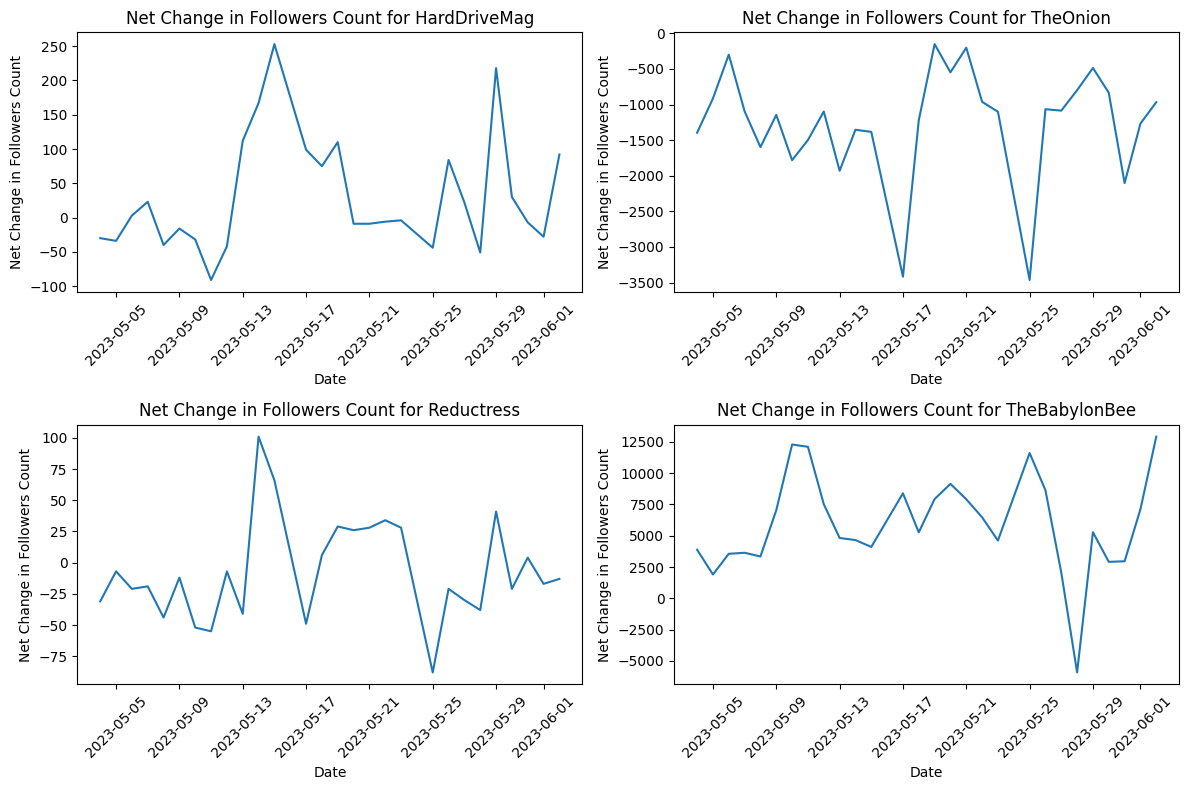

In [28]:
def plot_net_change_followers(combined_df):
    usernames = ['HardDriveMag', 'TheOnion', 'Reductress', 'TheBabylonBee']
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    for i, username in enumerate(usernames):
        row = i // 2
        col = i % 2
        df = combined_df[combined_df['username'] == username].copy() # it'll complain without copy() here
        df['net_change'] = df['followers'].diff()  # Calculate the net change
        ax = axes[row, col]
        ax.plot(df['date'], df['net_change'])
        ax.set_xlabel('Date')
        ax.set_ylabel('Net Change in Followers Count')
        ax.set_title(f'Net Change in Followers Count for {username}')
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

plot_net_change_followers(df_historical)

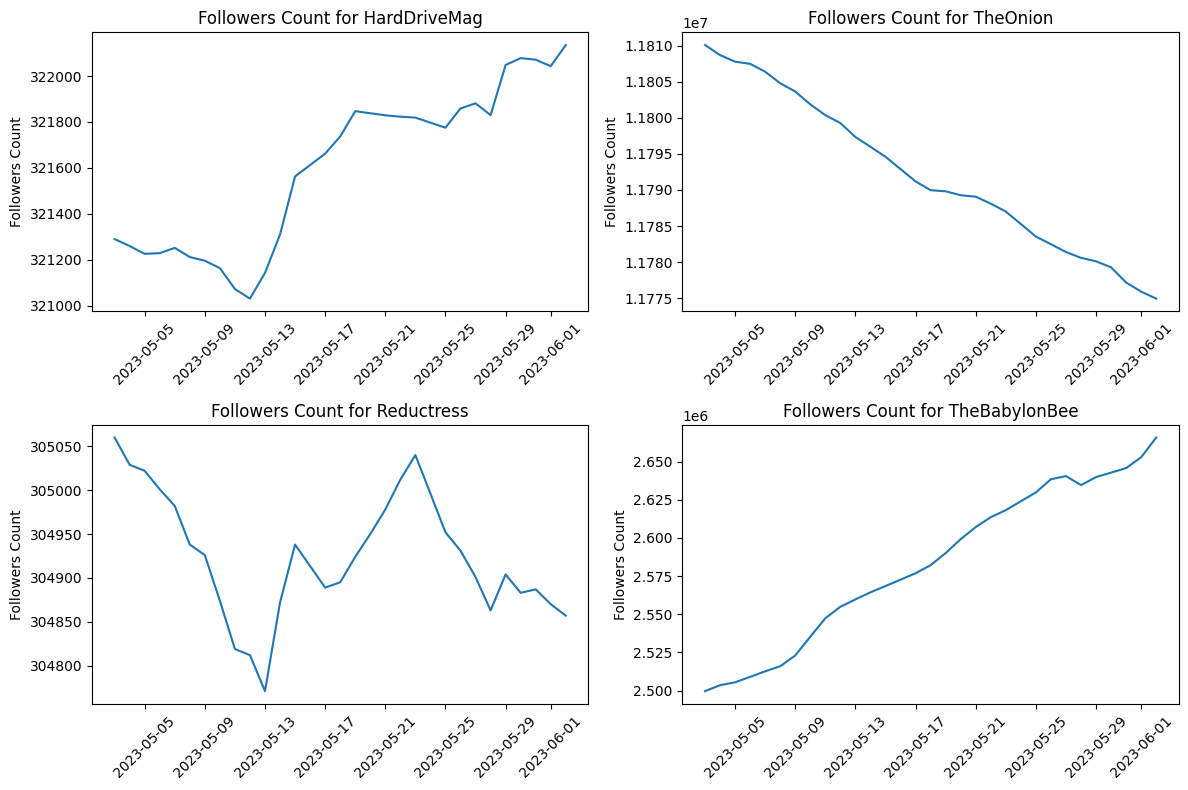

In [29]:
def plot_followers_count(combined_df):
    usernames = ['HardDriveMag', 'TheOnion', 'Reductress', 'TheBabylonBee']
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    for i, username in enumerate(usernames):
        row = i // 2
        col = i % 2
        df = combined_df[combined_df['username'] == username]
        ax = axes[row, col]
        ax.plot(df['date'], df['followers'])
        ax.set_ylabel('Followers Count')
        ax.set_title(f'Followers Count for {username}')
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

    # for username in usernames:
    #     df = combined_df[combined_df['username'] == username]
    #     plt.plot(df['date'], df['followers'])
    #     plt.xlabel('Date')
    #     plt.ylabel('Followers Count')
    #     plt.title(f'Followers Count for {username}')
    #     plt.xticks(rotation=45)
    #     plt.tight_layout()
    #     plt.show()


plot_followers_count(df_historical)

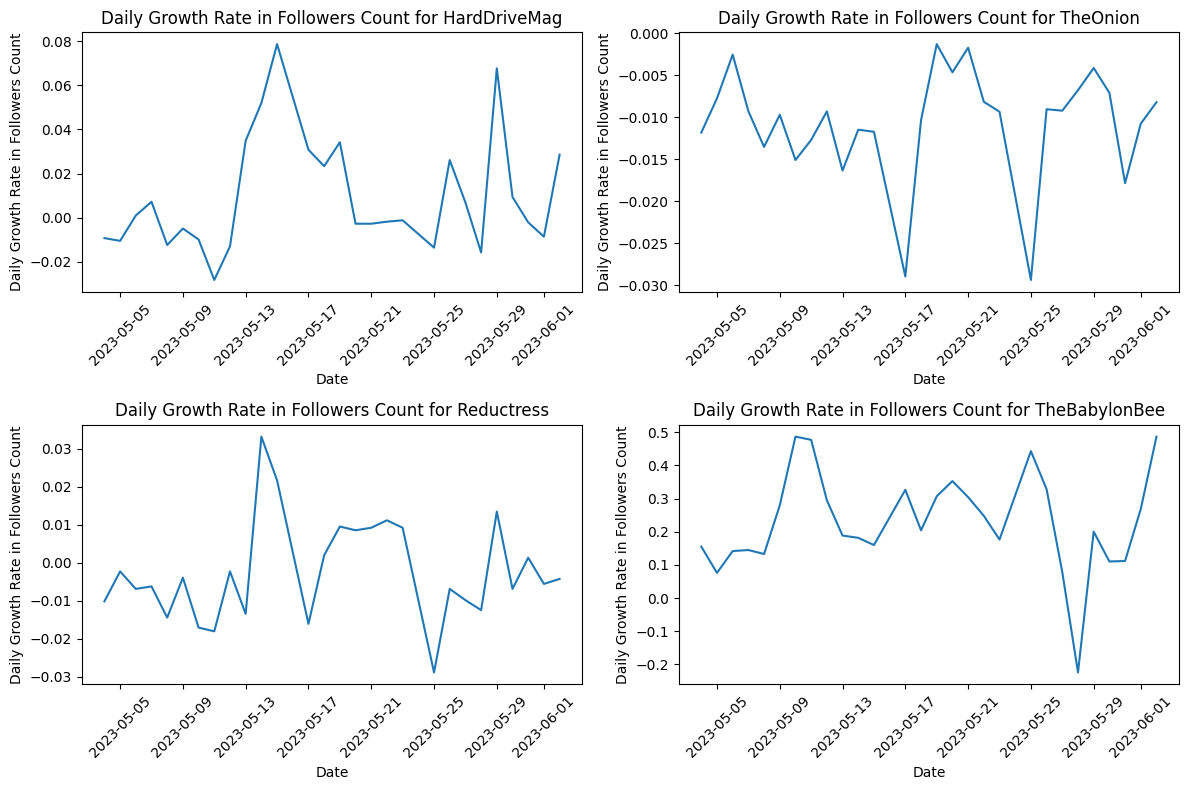

In [30]:
def plot_daily_change_followers(combined_df):
    usernames = ['HardDriveMag', 'TheOnion', 'Reductress', 'TheBabylonBee']
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    for i, username in enumerate(usernames):
        row = i // 2
        col = i % 2
        df = combined_df[combined_df['username'] == username].copy() # it'll complain without copy() here
        df['growth_rate'] = df['followers'].pct_change() * 100  # Calculate the net change
        ax = axes[row, col]
        ax.plot(df['date'], df['growth_rate'])
        ax.set_xlabel('Date')
        ax.set_ylabel('Daily Growth Rate in Followers Count')
        ax.set_title(f'Daily Growth Rate in Followers Count for {username}')
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

plot_daily_change_followers(df_historical)

In [31]:
def get_total_growth_rate_follower(df_combined):
    usernames = df_combined['username'].unique()
    df = pd.DataFrame(usernames, columns=['username'])
    total_growth_rates = {}
    for username in usernames:
        user_df = df_combined[df_combined['username'] == username]
        followers_start = user_df.iloc[0]['followers']
        followers_end = user_df.iloc[-1]['followers']
        total_growth_rate = ((followers_end - followers_start) / followers_start) * 100
        total_growth_rates[username] = total_growth_rate
    return total_growth_rates
        
list_total_growth_rate = get_total_growth_rate_follower(df_historical)

print(f"Total growth rate for followers across 30 days")
for username, growth_rate in list_total_growth_rate.items():
    print(f"{username}: {growth_rate:.2f}%")


Total growth rate for followers across 30 days
TheOnion: -0.30%
Reductress: -0.07%
HardDriveMag: 0.26%
TheBabylonBee: 6.65%
